Importing relevant packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#importing image dataset of concrete
img_dir = r"C:\Users\User\Downloads\Concrete with Cracks Image Classification Project\img_dataset"

#setup hyperparameters
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
SEED = 12345

In [3]:
#splitting dataset of concrete with crack into train and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=True)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  img_dir,
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=True)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


In [4]:
#creating list of train data class
train_dataclass_names = train_dataset.class_names
print(train_dataclass_names)
nClass=len(train_dataclass_names)

['Negative', 'Positive']


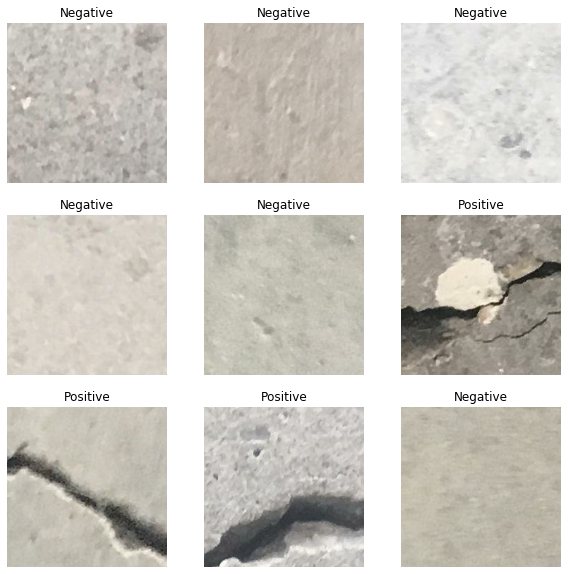

In [5]:
#plotting the images with labels
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataclass_names[labels[i]])
    plt.axis("off")
  plt.show()

In [6]:
val_batches = tf.data.experimental.cardinality(train_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [7]:
#create prefetch datasets for all 3 splits
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_dataset.prefetch(buffer_size=AUTOTUNE)
pf_val = validation_dataset.prefetch(buffer_size=AUTOTUNE)
pf_test = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
#create image segmentation pipeline using sequential API
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2)
])

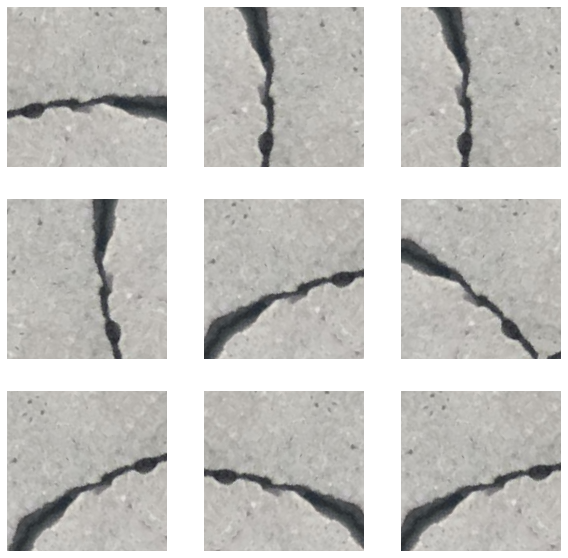

In [9]:
for images, labels in pf_train.take(1):
    first_image = images[0]
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255.0)
        plt.axis("off")
    plt.show()

In [10]:
#Create layer for data preprocessing
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

Build a base model

In [11]:
#Create the base model using MobileNetV2
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

#converts each 160x160x3 image into a 5x5x1200 block of features.
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

(32, 5, 5, 1280)


In [12]:
# Let's take a look at the base model architecture
print(base_model.summary())

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model

In [16]:
#construct the model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
print(len(model.trainable_variables))

2


In [19]:
#train the model
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

50/50 [==============================] - 13s 64ms/step - loss: 0.3850 - accuracy: 0.8119
initial loss: 0.38
initial accuracy: 0.81
Epoch 1/10
1000/1000 [==============================] - 132s 120ms/step - loss: 0.0703 - accuracy: 0.9816 - val_loss: 0.0175 - val_accuracy: 0.9962
Epoch 2/10
1000/1000 [==============================] - 118s 118ms/step - loss: 0.0159 - accuracy: 0.9960 - val_loss: 0.0102 - val_accuracy: 0.9975
Epoch 3/10
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.0070 - val_accuracy: 0.9981
Epoch 4/10
1000/1000 [==============================] - 122s 121ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0059 - val_accuracy: 0.9987
Epoch 5/10
1000/1000 [==============================] - 124s 124ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0046 - val_accuracy: 0.9987
Epoch 6/10
1000/1000 [==============================] - 124s 124ms/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.0047 - va

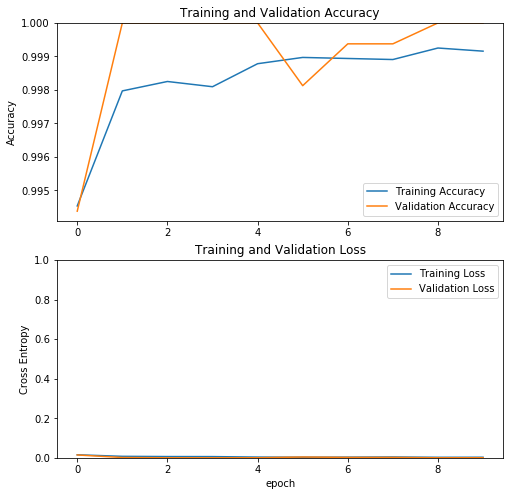

In [68]:
#build a graph to show learning curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Start the fine tuning and unfreeze the top layer of the model

In [20]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#Model compiling
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

print(len(model.trainable_variables))

Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                    

In [21]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
1000/1000 [==============================] - 196s 174ms/step - loss: 0.0401 - accuracy: 0.9871 - val_loss: 0.0047 - val_accuracy: 0.9981
Epoch 11/20
1000/1000 [==============================] - 167s 166ms/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 6.9240e-04 - val_accuracy: 1.0000
Epoch 12/20
1000/1000 [==============================] - 171s 170ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 5.6829e-04 - val_accuracy: 1.0000
Epoch 13/20
1000/1000 [==============================] - 171s 171ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 3.8025e-04 - val_accuracy: 1.0000
Epoch 14/20
1000/1000 [==============================] - 174s 174ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 1.4696e-04 - val_accuracy: 1.0000
Epoch 15/20
1000/1000 [==============================] - 179s 179ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 1.1450e-04 - val_accuracy: 1.0000
Epoch 16/20
1000/1000 [==============================] - 163s 163ms/step - loss: 0.005

Plot a graph to observe the result of acc, val_acc, loss and val_loss

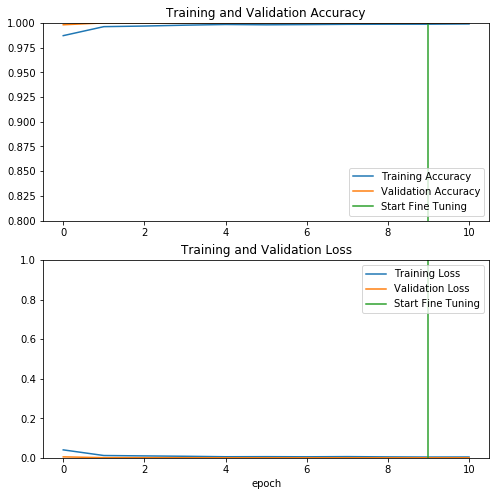

In [23]:
acc = []
val_acc = []
loss = []
val_loss = []

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Make a prediction and evaluation

200/200 [==============================] - 12s 59ms/step - loss: 0.0034 - accuracy: 0.9994
Test accuracy : 0.9993749856948853
Predictions:
 [1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1]
Labels:
 [1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1]


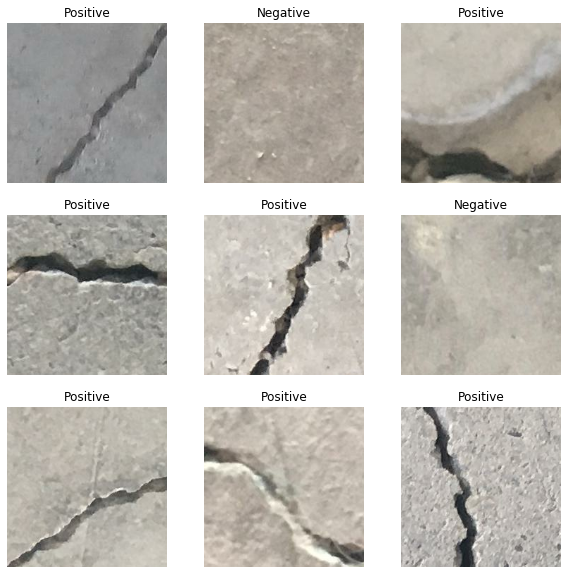

In [25]:
#Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(train_dataclass_names[predictions[i]])
  plt.axis("off")
plt.show()
